# Ensemble

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
# linear regression
linreg_train_test = pd.read_csv('linreg_20230810_output.csv')
linreg_upcoming = pd.read_csv('linreg_20230810_full_predictions.csv')

# light gbm
lgbm_train_test = pd.read_csv('lgbm_20230808_output.csv')
lgbm_upcoming = pd.read_csv('lgbm_20230808_full_predictions.csv')

# train_test 
def key_pred_creator(df,model_name):
    df['KEY'] = df['Team']+'_'+df['Season'].astype(str)
    df.columns = ['Actual',model_name+'_predictions','Team','Season','SUBSET','KEY']
    return df 

linreg_train_test = key_pred_creator(linreg_train_test,'linreg')
lgbm_train_test = key_pred_creator(lgbm_train_test,'lgbm')

train_test = lgbm_train_test.merge(linreg_train_test[['KEY','linreg_predictions']],how='left',on='KEY')

# upcoming 
linreg_upcoming = linreg_upcoming[['Team','Predicted Wins']].copy()
lgbm_upcoming = lgbm_upcoming[['Team','Predicted Wins']].copy()

linreg_upcoming.columns = ['Team','linreg_predictions']
lgbm_upcoming.columns = ['Team','lgbm_predictions']

upcoming = lgbm_upcoming.merge(linreg_upcoming,how='left',on='Team')

In [3]:
train_test

,Actual,lgbm_predictions,Team,Season,SUBSET,KEY,linreg_predictions
0,0.0,0.0,Hawks,2001,TRAIN,Hawks_2001,-0.420292
1,0.0,0.0,Cavaliers,2001,TRAIN,Cavaliers_2001,1.672332
2,0.0,0.0,Bulls,2001,TRAIN,Bulls_2001,-2.430140
3,0.0,0.0,Nuggets,2001,TRAIN,Nuggets_2001,2.017544
4,0.0,0.0,Warriors,2001,TRAIN,Warriors_2001,-1.163000
...,...,...,...,...,...,...,...
650,0.0,7.0,Jazz,2022,TEST,Jazz_2022,4.366006
651,16.0,10.0,Nuggets,2022,TEST,Nuggets_2022,5.767553
652,13.0,10.0,Heat,2022,TEST,Heat_2022,5.920710
653,2.0,10.0,Grizzlies,2022,TEST,Grizzlies_2022,3.078903


In [4]:
upcoming

,Team,lgbm_predictions,linreg_predictions
0,Nets,0.0,3.081857
1,Wizards,0.0,0.949770
2,Jazz,0.0,2.240234
3,Thunder,0.0,-0.834752
4,Spurs,0.0,-1.208438
5,Trail Blazers,0.0,0.023129
6,Pacers,0.0,0.416069
7,Magic,0.0,1.194045
8,Pistons,0.0,-0.576791
9,Hornets,0.0,-1.350558


In [5]:
train = train_test[train_test['SUBSET']=='TRAIN'].copy()
test = train_test[train_test['SUBSET']=='TEST'].copy()
x_train = train.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_train = train['Actual']
x_test = test.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_test = test['Actual']

In [6]:
x_train

,lgbm_predictions,linreg_predictions
0,0.0,-0.420292
1,0.0,1.672332
2,0.0,-2.430140
3,0.0,2.017544
4,0.0,-1.163000
...,...,...
620,7.0,4.696699
621,7.0,5.618615
622,7.0,2.565254
623,7.0,0.394479


## Modeling

In [7]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [8]:
linreg = LinearRegression()

In [9]:
param_grid = {
                'fit_intercept': [True,False]
            }

clf = GridSearchCV(linreg, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           verbose = 10, 
                           n_jobs = -1
                  )

In [10]:
# Fitting the model 
clf.fit(x_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tuned Hyperparameters : {'fit_intercept': True}
Best Score : -3.5688677618914513


In [11]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

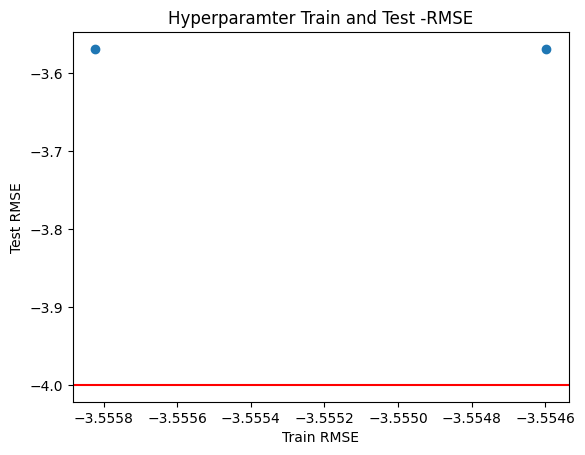

In [12]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [13]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002938,0.000166,0.001196,0.000055,True,{'fit_intercept': True},-3.485154,-3.580934,-3.446058,-3.448330,...,-3.568868,0.164916,1,-3.577578,-3.551358,-3.588048,-3.584187,-3.471816,-3.554598,0.043326
1,0.002900,0.000201,0.001315,0.000103,False,{'fit_intercept': False},-3.482172,-3.582967,-3.449181,-3.450811,...,-3.568980,0.162871,2,-3.579539,-3.552257,-3.588360,-3.584849,-3.474105,-3.555822,0.042788


In [14]:
clf.best_estimator_.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

## Evaluation

### Train 

In [15]:
predictions = clf.predict(x_train)

In [16]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [17]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['Team']
train_output['Season'] = train['Season']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [18]:
train_output.tail()

,Actual,Prediction,Team,Season
616,7.0,4.856059,Bucks,2021
621,7.0,4.918891,Suns,2021
614,0.0,5.332163,Lakers,2021
618,0.0,5.734878,Nets,2021
624,2.0,6.425688,Jazz,2021


In [19]:
train_results

,MSE,MAE,R2,RMSE
1,12.649707,2.515106,0.322716,3.556643


### Test 

In [20]:
predictions = clf.predict(x_test)

In [21]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [22]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['Team']
test_output['Season'] = test['Season']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [23]:
test_output.head()

,Actual,Prediction,Team,Season
635,0.0,-1.558286,Thunder,2022
627,0.0,-0.449717,Rockets,2022
631,0.0,-0.363373,Magic,2022
638,0.0,-0.292559,Hornets,2022
637,0.0,-0.285971,Pistons,2022


In [24]:
test_results

,MSE,MAE,R2,RMSE
1,12.389,2.579982,0.327659,3.519801


### Upcoming Season 

In [25]:
x_up = upcoming[clf.best_estimator_.feature_names_in_]
x_up.head()

,lgbm_predictions,linreg_predictions
0,0.0,3.081857
1,0.0,0.949770
2,0.0,2.240234
3,0.0,-0.834752
4,0.0,-1.208438


In [26]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['Team']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
10,Rockets,-1.173078,-1,R1/Lottery
9,Hornets,-0.940275,-1,R1/Lottery
4,Spurs,-0.856004,-1,R1/Lottery
3,Thunder,-0.634426,-1,R1/Lottery
8,Pistons,-0.481466,0,R1/Lottery
5,Trail Blazers,-0.125741,0,R1/Lottery
6,Pacers,0.107255,0,R1/Lottery
1,Wizards,0.423716,0,R1/Lottery
7,Magic,0.568560,1,R1/Lottery
11,Raptors,1.024124,1,R1/Lottery


In [27]:
len(list(final_output['Team']))

30

In [28]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [29]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [30]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
20,76ers,4.497524,4,Second Round
14,Celtics,5.102233,5,Second Round
25,Bucks,5.740110,6,Second Round
29,Cavaliers,6.144841,6,Second Round


In [31]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
27,Clippers,3.921236,4,R1/Lottery
19,Suns,4.518814,5,Second Round
22,Warriors,4.999875,5,Second Round
21,Nuggets,5.463006,5,Second Round


In [32]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
14,Celtics,5.102233,5,Second Round
21,Nuggets,5.463006,5,Second Round
25,Bucks,5.740110,6,Second Round
29,Cavaliers,6.144841,6,Second Round


## Writing Info 

In [33]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [34]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,12.649707,2.515106,0.322716,3.556643,TRAIN
1,12.389,2.579982,0.327659,3.519801,TEST


In [35]:
model_name = input()

ensemble_linreg_lgbm


In [36]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

ensemble_linreg_lgbm_cv_results.csv
ensemble_linreg_lgbm_output.csv
ensemble_linreg_lgbm_results.csv
ensemble_linreg_lgbm_full_predictions.csv
ensemble_linreg_lgbm_ecf_predictions.csv
ensemble_linreg_lgbm_wcf_predictions.csv
ensemble_linreg_lgbm_finals_predictions.csv


In [37]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [38]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [39]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [40]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
647,7.0,4.671165,76ers,2022,TEST
643,1.0,5.490172,Bucks,2022,TEST
652,13.0,5.838059,Heat,2022,TEST
654,11.0,7.423363,Celtics,2022,TEST


In [41]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
641,0.0,4.310678,Mavericks,2022,TEST
642,6.0,4.420864,Warriors,2022,TEST
648,6.0,5.632843,Suns,2022,TEST
651,16.0,5.747244,Nuggets,2022,TEST


In [42]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
648,6.0,5.632843,Suns,2022,TEST
651,16.0,5.747244,Nuggets,2022,TEST
652,13.0,5.838059,Heat,2022,TEST
654,11.0,7.423363,Celtics,2022,TEST
